# CPSC 330 Lecture 19

Outline:

- Announcements (5 min)
- Clustering intro (10 min)
- $k$-means clustering (10 min)
- Choosing $k$: elbow (5 min)
- Choosing $k$: silhouette (10 min)
- Break (5 min)
- Distances (5 min)
- DBSCAN (10 min)
- Hierarchical clustering (10 min)

Piazza:

- True/False questions

In [1]:
import numpy as np
import random

from sklearn import datasets
from scipy.spatial import distance
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.patches import Ellipse, Polygon

# plt.style.use("seaborn")

In [2]:
plt.rcParams['font.size'] = 16

Some extra functions for plotting, the code is included in this repo:

In [3]:
from support_functions import *

## Announcements

- How are people doing? https://piazza.com/class/kb2e6nwu3uj23?cid=545
- hw5 and hw6 grading very close to finished (thanks for your patience).
- hw7 deadline passed, hw8 coming today.
- Pre-watching videos for next time, if you can.
- Today's class: still a WIP.
- Today is the last class with lots of code. Rest of the course:
  - 2 lectures on communication for ML
  - 2 lectures on ethics for ML
  - final lecture (hopefully) on model deployment to an API

# Supervised vs Unsupervised Learning

- Most of what we do in this course is supervised learning: given $x$, try to predict $y$
- But the nearest neighbour item recommendations we did was unsupervised learning.
  - We did not have labels telling is the "correct answer" for our recommendations.
- This is the same thing here. It is also unsupervised learning.

Let's load in our housing dataset again (I know, I REALLY need to put this into a function or store the preprocessed data as a csv).

In [4]:
housing_df = pd.read_csv("data/housing.csv", index_col=0)

- This time I'll NOT do a train-test split. 
  - There might be reasons to still do this, it depends. 
  - For now I won't bother, I just want to cluster the houses.
- I will also not separate into X and y

In [5]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']

numeric_features += ['SalePrice'] # treat this as a regular numeric feature here!!!

Note we don't have a "target" column, we're just treating `SalePrice` as a regular feature here.

In [6]:
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(housing_df.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [7]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [8]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [9]:
preprocessing.fit(housing_df);

In [10]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [11]:
housing_df_enc = pd.DataFrame(preprocessing.transform(housing_df), index=housing_df.index, columns=new_columns)
housing_df_enc.shape

(1460, 300)

Can we divide these 1460 houses into groups of similar houses?

## Clustering intro (10 min)

- We want to group the observations in such a way that:
    1. Examples in the same group are as similar as possible;
    2. Examples in different groups are as different as possible.
    
A very interesting talk about an application of clustering: [Malcom Gladwell - Spaghetti Sauce](https://www.ted.com/talks/malcolm_gladwell_on_spaghetti_sauce?language=en).

I was thinking recently that a politician choosing their platform is a related problem. 

#### Classification vs. clustering

In [12]:
## Wine dataset
wine = datasets.load_wine()
data_wine = pd.DataFrame(wine.data, columns=wine.feature_names) 
data_wine['target'] = wine.target_names[wine.target]

## Iris dataset
iris = datasets.load_iris() # loading the iris dataset
features = iris.data # get the input data
labels = iris.target_names[iris.target] # get the responses, in this case the specie of the flowers

# Reducing the dimensionality for plotting purposes 
pca = PCA(n_components=2) 
pca.fit(features)
data_iris = pd.DataFrame(pca.transform(features), columns=['$Z_1$', '$Z_2$'])
data_iris['target'] = labels

/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w + h})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w + h})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w + h})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w + h})


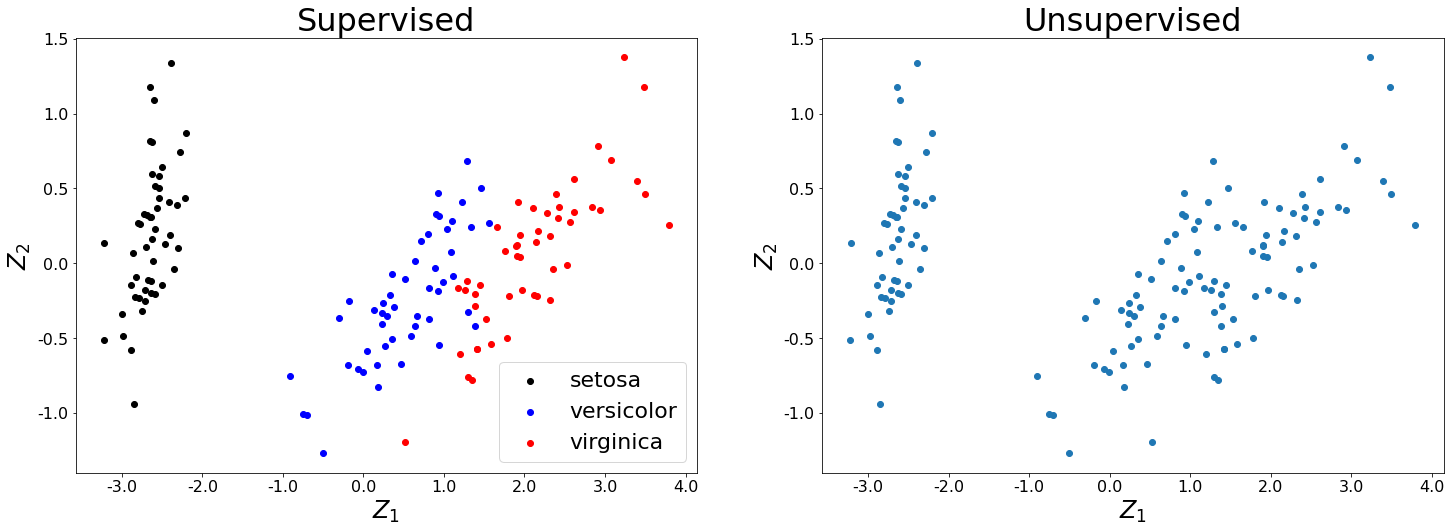

In [13]:
plot_sup_x_unsup(data_iris, 8, 8)

- Although close to the idea of classification, clustering is unsupervised, i.e., the labels are unknown.
- There is no point in thinking of "true" or "correct" cluster; the best we can do is to talk about optimal (in some sense) cluster.
- Generally, not even the number of clusters is known.
  - How many spaghetti sauce types should we make?

## $k$-means clustering (10 min)

- We want find clusters (groups) of data points.
- Think of colouring the points (e.g., black, red, blue), such that points with the same colour are close to each other.
  - But remember that the colours themselves have no significance.

/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w})


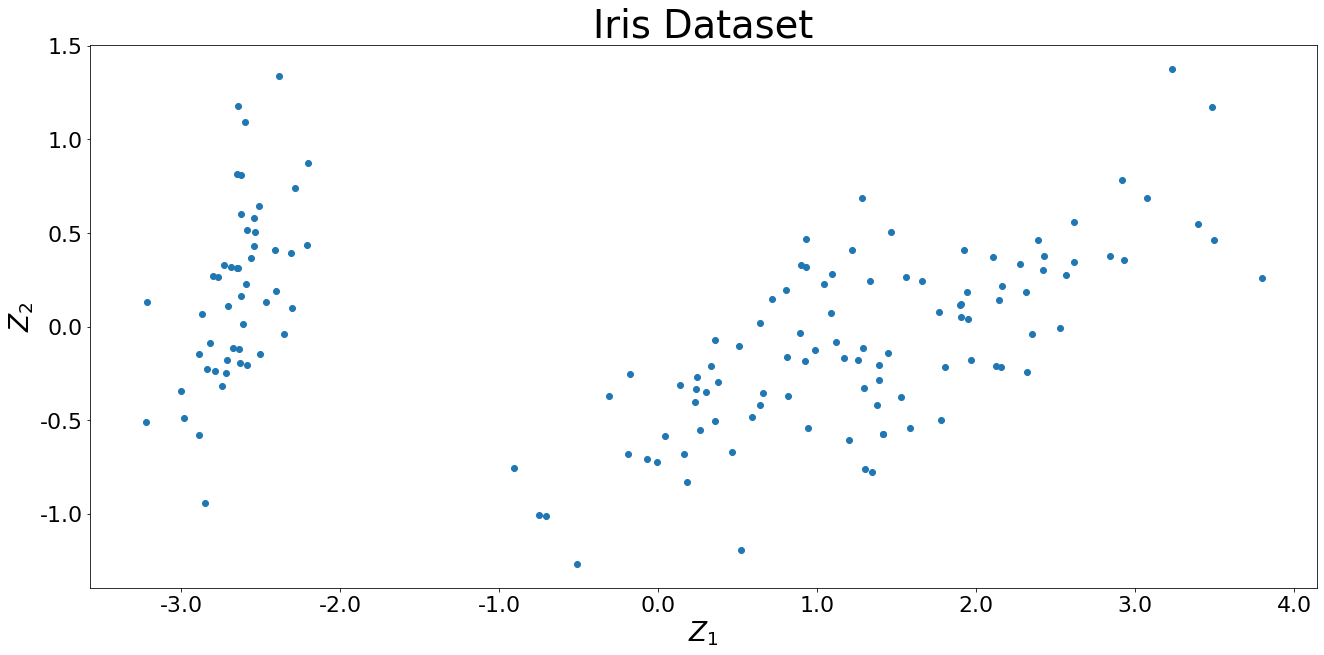

In [14]:
plot_unsup(data_iris, 22, 10, "Iris Dataset")

- With $k$-means clustering The number of clusters, $k$, is a hyperparameter.


### Algorithm:

Two steps:
1.  Assign each example to the closest center.
2.  Estimate new centers as _average_ of example in a cluster.

Repeat 1. and 2. until centers and assignments do not change anymore.

In [15]:
iris_2d = data_iris.iloc[:,:2]

In [16]:
kmeans = KMeans()
kmeans.fit(iris_2d);

In [17]:
clusters = kmeans.predict(iris_2d)

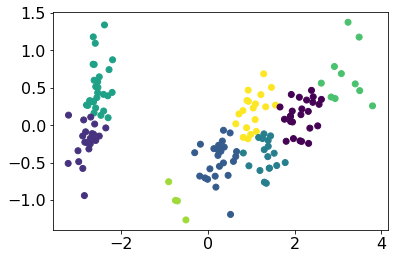

In [18]:
plt.scatter(iris_2d.iloc[:,0], iris_2d.iloc[:,1], c=clusters);

- sklearn's `KMeans` uses 8 clusters by default

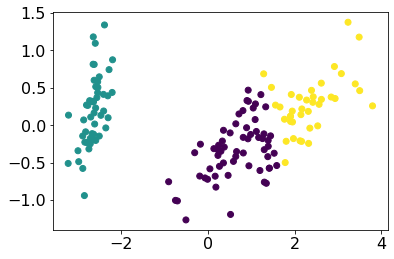

In [19]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(iris_2d);
clusters = kmeans.predict(iris_2d)
plt.scatter(iris_2d.iloc[:,0], iris_2d.iloc[:,1], c=clusters);

- I guess this looks reasonable. 
- The default sklearn `KMeans` is deterministic up to a permutation of the colours (try running the code again).
- You can set `random_state` to avoid this.
- The "classic" k-means is random and can give bad results, I suggest sticking to the defaults.

#### sklearn syntax

- So, what exactly is happening here during `fit` and `predict`?
- `fit` does two things:

1. Assigns each point to a cluster
2. Creates a "cluster centre" for that point

In [20]:
kmeans.predict(iris_2d)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

- Note that these labels are arbitrary (they are the same as the colours).

In [21]:
kmeans.cluster_centers_

array([[ 0.66567601, -0.3316042 ],
       [-2.64241546,  0.19088505],
       [ 2.34652659,  0.27393856]])

- Here we have 3 points in 2D space.
- In our housing dataset each cluster centre will be a house, as you'll see soon.

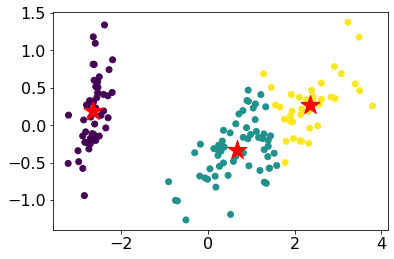

In [22]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(iris_2d);
clusters = kmeans.predict(iris_2d)
plt.scatter(iris_2d.iloc[:,0], iris_2d.iloc[:,1], c=clusters);
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*', c="r", s=400);

Above we can see the cluster centre of each cluster. 

Question: could there be a deployment phase for clustering?

<br><br><br><br><br><br>

- Yes, e.g. what sauce would a new person buy?
- Let's check for the features $(0,0)$ (not in training set):

In [23]:
kmeans.predict(np.zeros((1,2)))

array([1], dtype=int32)

So you could also do a train-test split here and assign test points.

#### Applying this to the housing data

In [24]:
housing_df_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,BsmtExposure_Mn,BsmtExposure_No,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(housing_df_enc);

In [26]:
preds = kmeans.predict(housing_df_enc)
preds

array([1, 0, 1, ..., 1, 0, 0], dtype=int32)

In [27]:
housing_raw_clust = housing_df.assign(cluster=preds)
housing_raw_clust

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,cluster
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,1
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,2
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,1


Looks like old/small houses selling for less.

In [28]:
housing_raw_clust.query("cluster == 0")[["YearBuilt", "OverallQual", "SalePrice", "GrLivArea", "LotArea"]].mean()

YearBuilt        1951.133333
OverallQual         5.191026
SalePrice      131501.910256
GrLivArea        1248.985897
LotArea          9162.164103
dtype: float64

In [29]:
housing_raw_clust.query("cluster == 1")[["YearBuilt", "OverallQual", "SalePrice", "GrLivArea", "LotArea"]].mean()

YearBuilt        1991.363897
OverallQual         7.005731
SalePrice      233353.604585
GrLivArea        2005.257880
LotArea         11280.954155
dtype: float64

In [30]:
housing_raw_clust.query("cluster == 2")[["YearBuilt", "OverallQual", "SalePrice", "GrLivArea", "LotArea"]].mean()

YearBuilt        1997.525680
OverallQual         7.283988
SalePrice      242093.800604
GrLivArea        1626.987915
LotArea         12903.407855
dtype: float64

These two clusters look somewhat different in terms of size, and cluster 1 is older

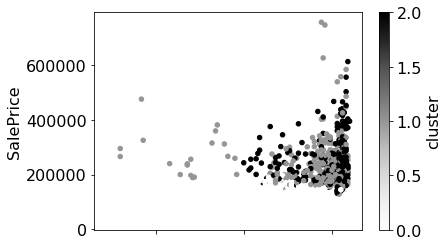

In [31]:
housing_raw_clust.plot.scatter(x="YearBuilt", y="SalePrice", c="cluster");

- It's pretty hard to digest this in so many dimensions. 
- Also **keep in mind I performed the clustering in the encoded space**, meaning there were

In [32]:
housing_df_enc.shape

(1460, 300)

300 features, not

In [33]:
housing_df.shape

(1460, 80)

80 features when the clustering was performed

## Choosing $k$: elbow (5 min)

- Since in unsupervised learning we do not have the $y$ values, it becomes very difficult to objectively measure the effectiveness of the algorithms.
- There is no definitive approach.
- However, some strategies might be useful to help you determine $k$.

#### The Elbow method

- Find a measure of how well the clusters "fit" the data
  - Often the sum of intra-cluster distances, aka _inertia_.
  - Question: would we want this to be small or large?

<br><br><br><br><br><br>

- The problem is, we can't just look for a $k$ that minimizes the sum of intra-cluster distance because it decreases as $k$ increases.
- But we can evaluate the trade-off: "small k" vs "small intra-cluster distances".

In [34]:
kmeans_sweep_iris = {k : KMeans(n_clusters = k, random_state=1).fit(iris_2d) for k in range(1,10)}

In [35]:
def plot_elbow(kmeans_dict, elbow=None, w=11, h=5):
    plt.figure(figsize = (w,h))
    if elbow is not None:
        plt.axvline(x=elbow, linestyle='-.', c="black")
    plt.plot(kmeans_dict.keys(), [km.inertia_ for km in kmeans_dict.values()], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

63.81994202200125

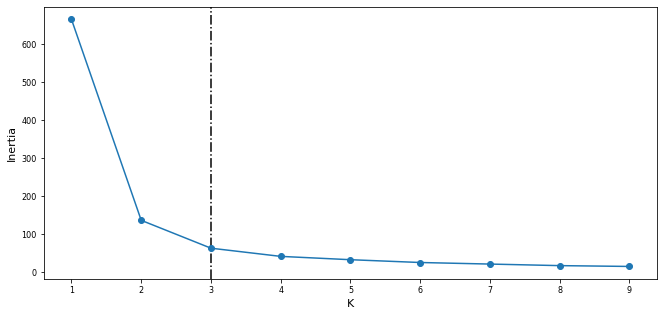

In [36]:
plot_elbow(kmeans_sweep_iris, elbow=3)
kmeans_sweep_iris[3].inertia_

From the above plot, we could argue between two and three clusters are enough.

And for the housing data:

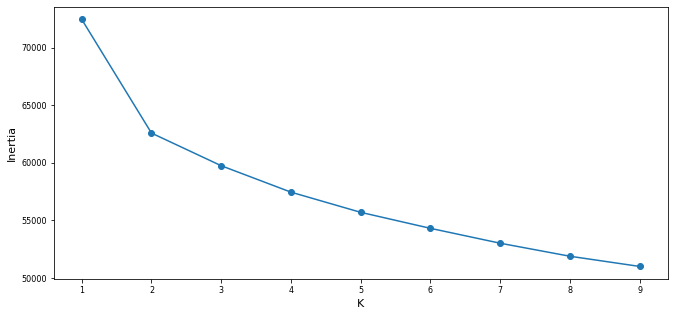

In [37]:
kmeans_sweep_housing = {k: KMeans(n_clusters = k, random_state=1).fit(housing_df_enc) for k in range(1,10)}
plot_elbow(kmeans_sweep_housing)
# We could argue between two and three clusters are enough;

This one is a bit less clear.

## Choosing $k$: silhouette method (10 min)


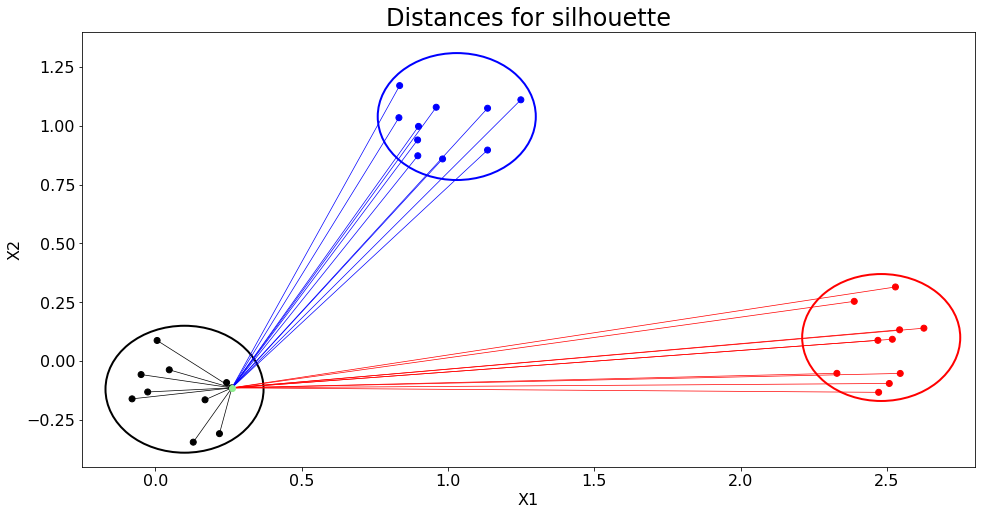

In [38]:
plot_silhouette_dist(16, 8)

First step: find the _second best_ cluster for each point. Let's take the green point as an example. Here are the steps:

- Average the distances of the green point to the other points in the same cluster.
  - These distances are represented  by the black lines;
  

- Average the distances of the green point to the points in the <font color="blue">blue</font> cluster;
  - These distances are represented  by the <font color="blue">blue</font> lines;


- Average the distances of the green point to the points in the <font color="red">red</font> cluster;
  - These distances are represented  by the  <font color="red">red</font>  lines;

Then, since the average distance to the blue cluster is lower than to the red cluster, the blue cluster is considered to be the neighbour cluster - (the second-best choice for the green point to live, after the black cluster). 

The silhouette method compares the average distance to the neighbour cluster to the average distance to the given cluster to come up with a silhouette coefficient for that example (`sklearn.metrics.silhouette_samples`).

- Unlike the inertia, **larger values are better** because they indicate that the point is further away from neighbouring clusters.
- Unlike the inertia, the overall silhouette score gets **worse** as you add more clusters because you end up being closer to neighbouring clusters. 
  - Thus, as with intertia, you will not see a "peak" value of this metric that indicates the best number of clusters.
- We can visualize the silhouette score for each example individually in a silhouette plot (hence the name), see below.
  - (I guess it should be possible to do this with the inertia/distance as well, but I haven't seen it done. Maybe because the score are not normalized?)

Attribution: the following code is adapted from the sklearn docs [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

In [39]:
# collapse this cell

def make_sklearn_sil_plots(X, params_list=None, clusterer_class=KMeans):

    if params_list is None:
        params_list = [{"n_clusters" : n} for n in range(2,8)]
    
    clusterers = [clusterer_class(**params).fit(X) for params in params_list]
    
    for nn, clusterer in enumerate(clusterers):
        n_clusters = np.max(clusterer.labels_) + 1
        
        # Create a subplot with 1 row and 2 columns
        
        if X.shape[1] == 2:
            fig, (ax1, ax2) = plt.subplots(1, 2)
        else:
            fig, ax1 = plt.subplots(1, 1)

        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#         cluster_labels = clusterer.predict(X)
        cluster_labels = clusterer.labels_

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        if X.shape[1] == 2:
            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k')

            # Labeling the clusters
            try:
                centers = clusterer.cluster_centers_
            except AttributeError:
                pass
            else:
                # Draw white circles at cluster centers
                ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c="white", alpha=1, s=200, edgecolor='k')

                for i, c in enumerate(centers):
                    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                                s=50, edgecolor='k')

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for " + clusterer_class.__name__ +
                      " with %s" % params_list[nn]),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7056703225102109
For n_clusters = 3 The average silhouette_score is : 0.597676421954799
For n_clusters = 4 The average silhouette_score is : 0.5583053424690901
For n_clusters = 5 The average silhouette_score is : 0.5535698812209562
For n_clusters = 6 The average silhouette_score is : 0.44412097601443273
For n_clusters = 7 The average silhouette_score is : 0.43220987613066464


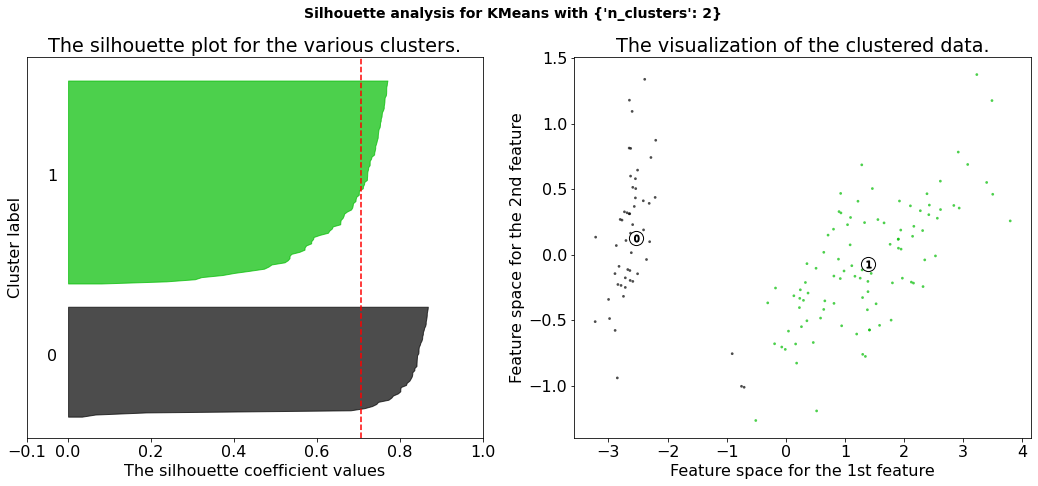

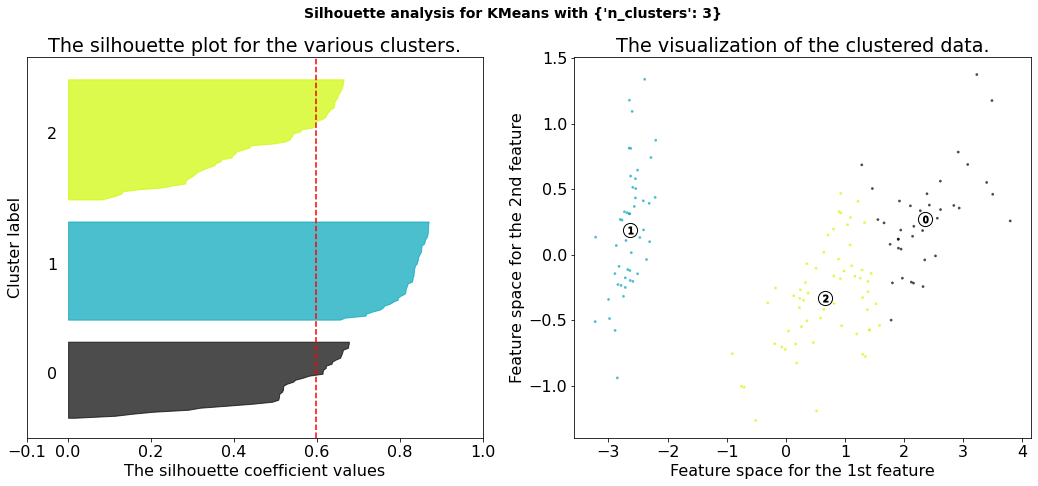

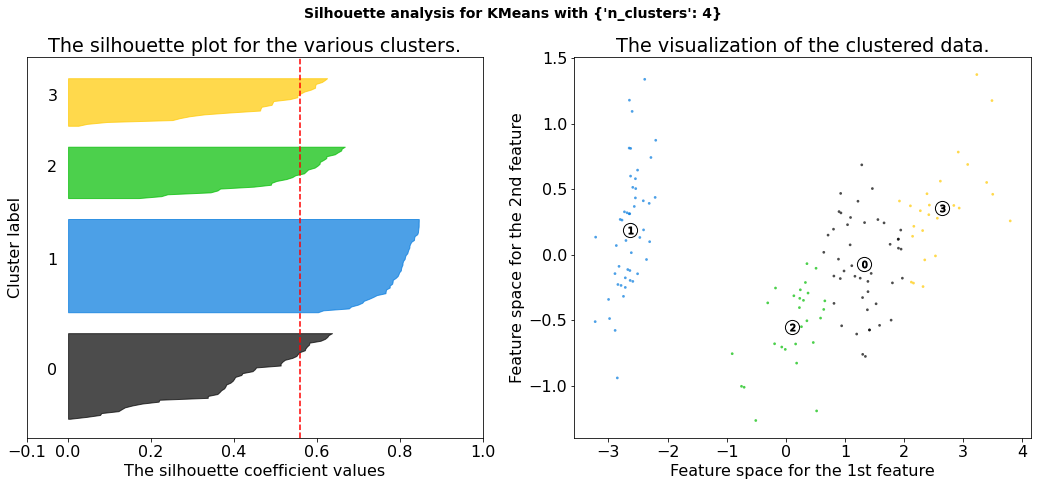

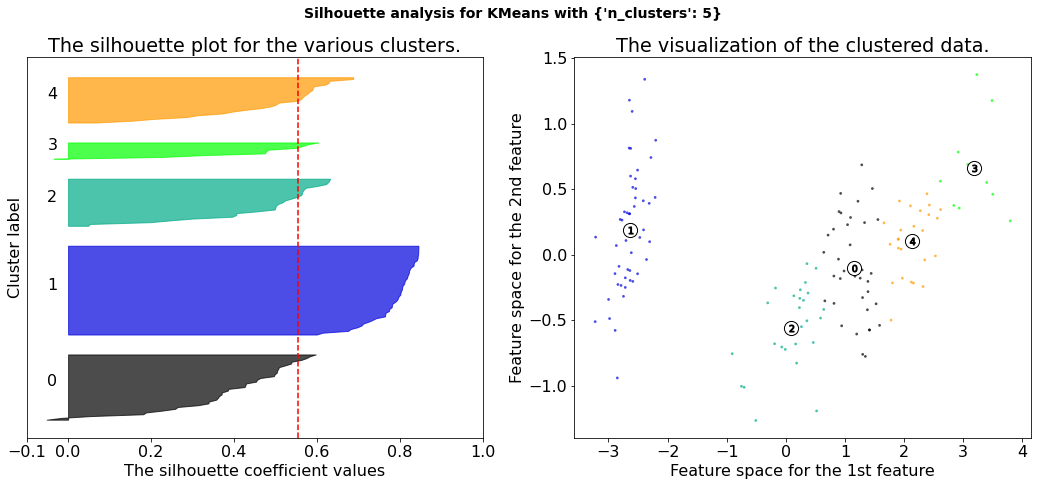

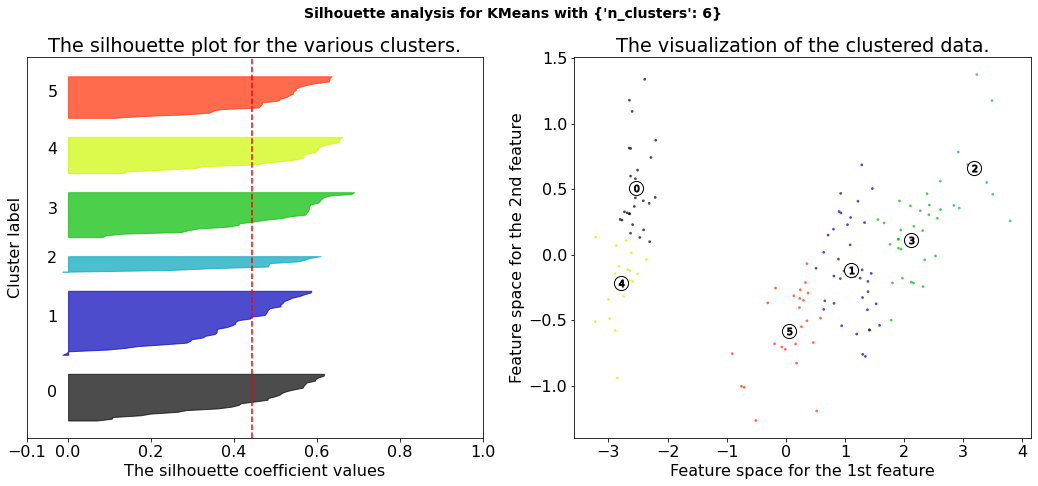

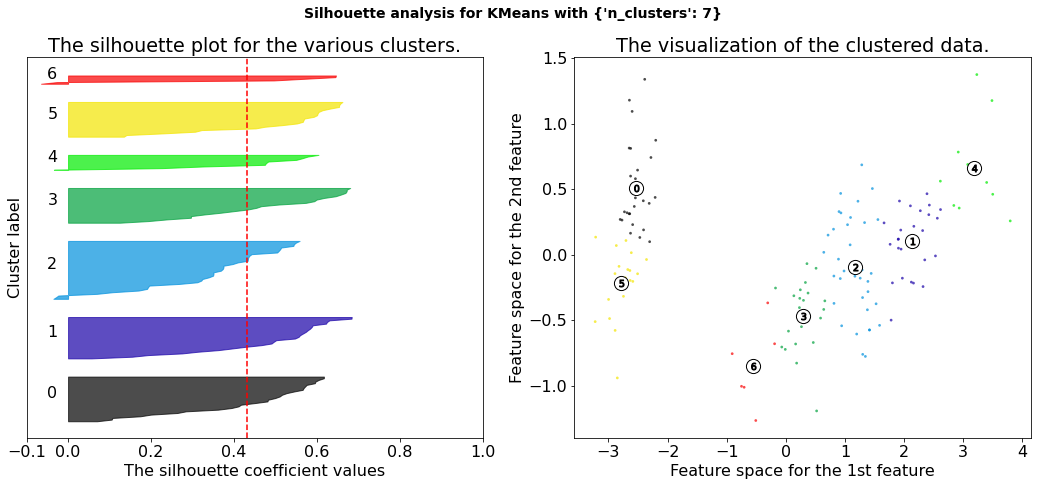

In [40]:
make_sklearn_sil_plots(iris_2d.values)

What to look for in these plots:

- The thickness of each silhouette indicates the cluster size.
- The shape of each silhouette indicates the "goodness" for points in each cluster.
- The length (or area) of each silhouette indicates the goodness of each cluster.
  - A slower dropoff (more rectangular) indicates more points are "happy" in their cluster.

For example, with $n=2$ or $n=3$ above we have "thick" silhouettes.

- One can also plot an overall silhouette score for each number of clusters.
- The overall index (`sklearn.metrics.silhouette_score`) is the average across all examples.

In [41]:
def plot_silhouette(x,kmeans_dict,w=11,h=5):
    s = [metrics.silhouette_score(x,km.labels_) for k, km in kmeans_dict.items() if k>1]
    plt.figure(figsize=(w,h))
    plt.plot([k for k in kmeans_dict if k>1], s);
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("s", fontsize=w)
#     ax.set_title("Silhouette: Iris Dataset with $k$-means partitions", fontsize=w+h)
#     ax.axvline(x=2, c='black', linestyle='-.')

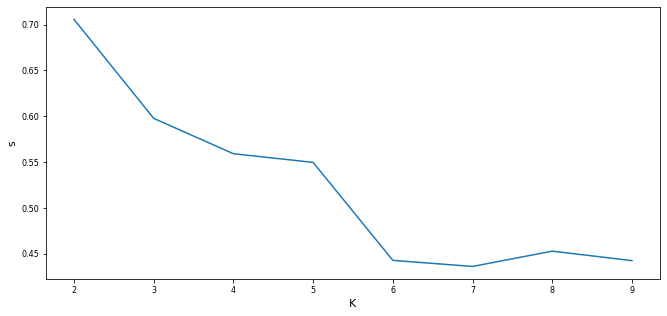

In [42]:
plot_silhouette(iris_2d.values,kmeans_sweep_iris)

As mentioned above, this looks similar to an inertia plot but

- Higher is better
- Things get worse with more clusters
- These two effects cancel out and you get the curve going downward as you add more clusters!

We can do the same for the housing data:

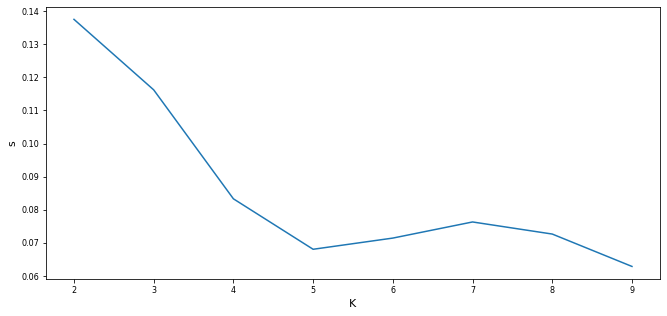

In [43]:
plot_silhouette(housing_df_enc,kmeans_sweep_housing)

For n_clusters = 2 The average silhouette_score is : 0.13753891557145131
For n_clusters = 3 The average silhouette_score is : 0.11625025253782073
For n_clusters = 4 The average silhouette_score is : 0.08300644528519802
For n_clusters = 5 The average silhouette_score is : 0.06820796878470758
For n_clusters = 6 The average silhouette_score is : 0.07248716287441757
For n_clusters = 7 The average silhouette_score is : 0.07050921475463715


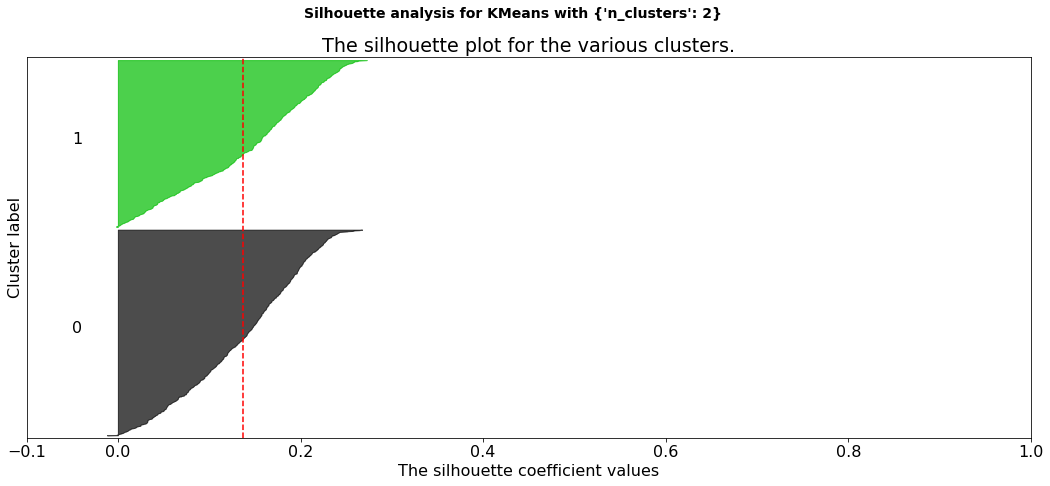

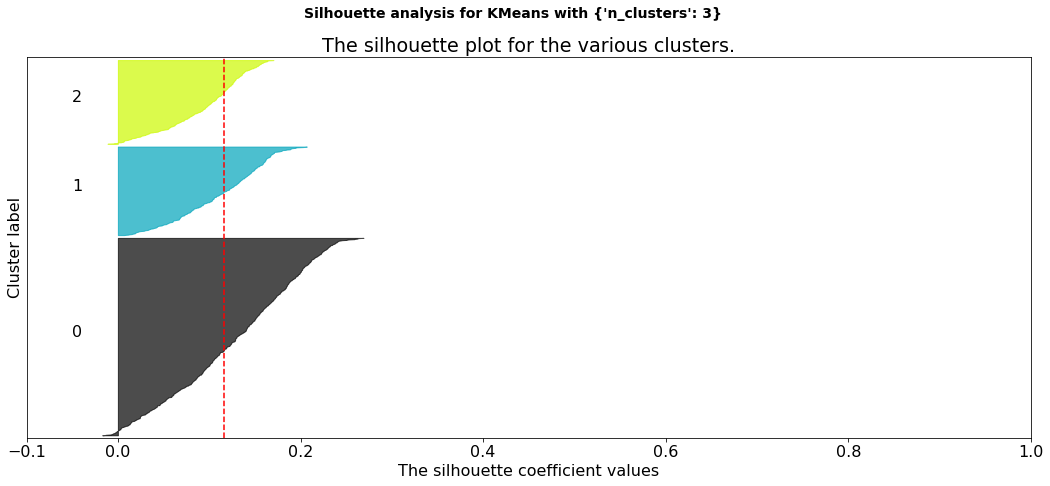

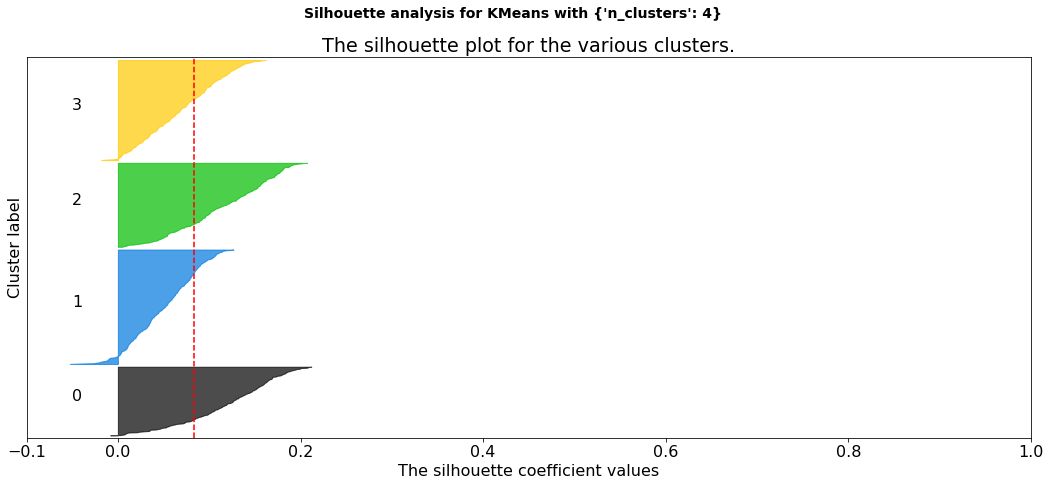

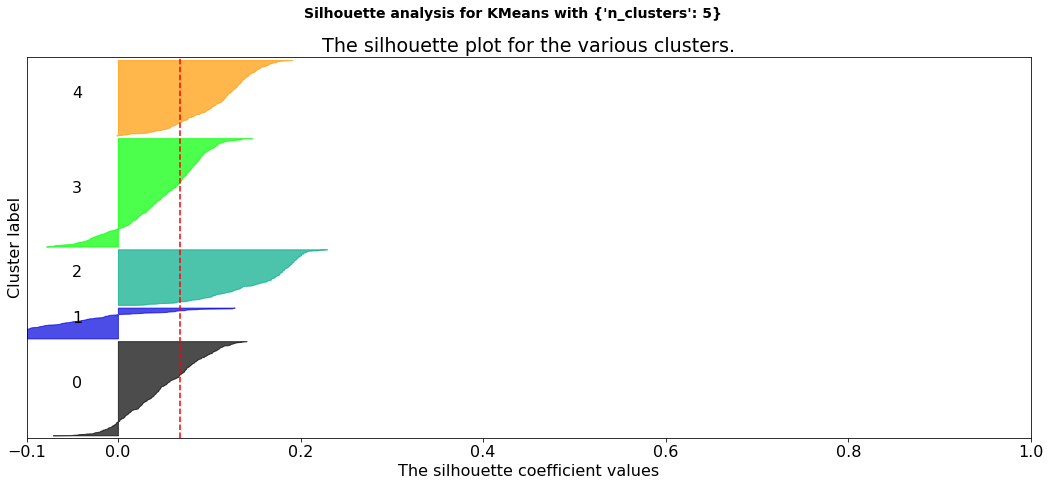

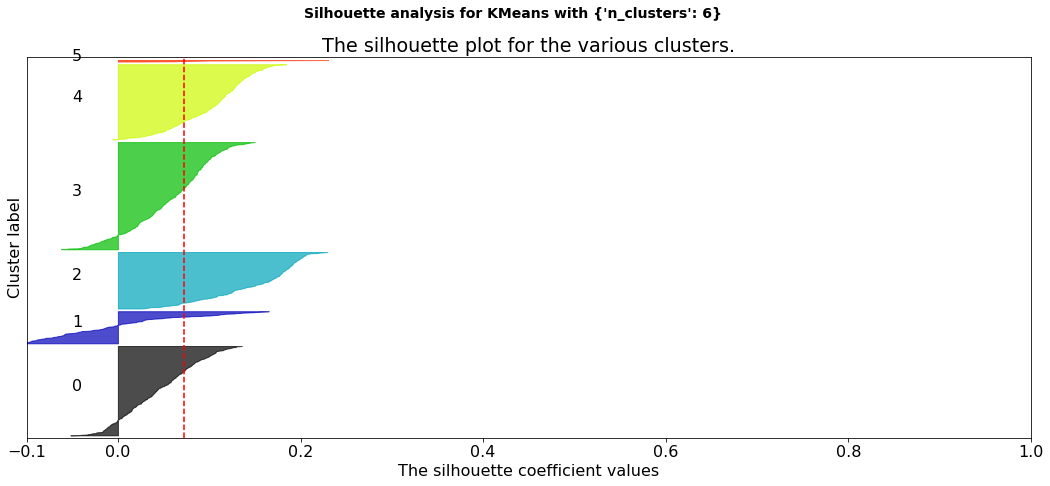

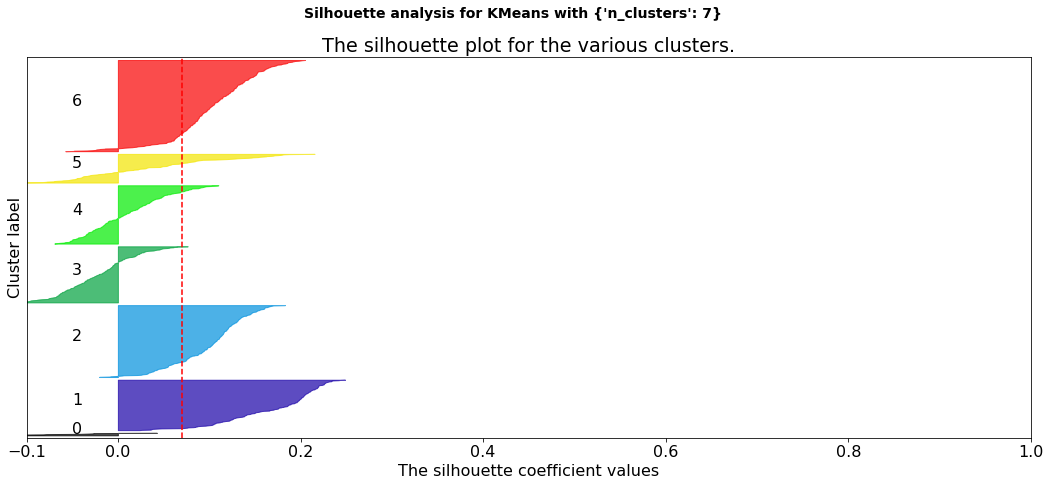

In [44]:
make_sklearn_sil_plots(housing_df_enc.values)

- The silhouette coefficients are technically between $-1$ and $+1$ but typically between $0$ and $+1$ (sort of like $R^2$).
  - $0$ means close to another cluster, $+1$ means far from other clusters (good)
- Unlike inertia, the silhouette method can be used with any clustering algorithm. 
- This, it can also be used to compare between different clustering algorithms (more on this coming).

## Break (5 min)

REMINDER TO RESUME RECORDING

## Distance metrics (5 min)

- Distances metrics are used to measure the dissimilarity between points.
- There are many different distance measures out there - we talked about a few in the nearest neighbours lecture. 
- The function `scipy.spatial.distance.cdist` is very helpful for calculating distance.


Although this might look just as required step to introduce the clustering algorithms, this is a fundamental step: 

<blockquote cite="http://www.worldwildlife.org/who/index.html">
<i> "Specifying an appropriate dissimilarity measure is far more important in obtaining success with clustering than choice of clustering algorithm."</i>
 (Hastie, Tibshirani & Friedman, The Elements of Statistical Learning, 2nd Edition, p. 506).
</blockquote>

- Defining the distance to be used by the clustering algorithm is how we answer the question: what is similar?
- However, selecting an appropriate distance measure is very tricky and there is no general methodological recipe for it.
- This requires _domain knowledge_.
- Be very careful when using Euclidean distance on non-scaled data.


Example: our housing data.

In [45]:
housing_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Question: did we need to transform our data to numeric?

<br><br><br><br><br><br>

- Well, not necessarily, if our distance function can take in the right data type!
- For example in our New York Airbnb data, we could look at the actual distance between neighbourhoods. 
- Here, we could account for the month sold issue that 1=Jan and 12=Dec.

#### Clustering with distances only

- Some clustering algorithms require the $x$ vectors
  - E.g. $k$-means, for averaging the points to find cluster centres
- Some clustering algorithms only require the ability to compute distances between any two points
  - E.g. DBSCAN (see below) - to verify
- Some clustering algorithms only require the distance matrix
  - See sklearn's [SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) with `affinity='precomputed'`.

## DBSCAN (10 min)

In [46]:
# collapse this cell

x1 = np.random.multivariate_normal(mean = [0,0], cov=np.diag([3,3]), size = 200)
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [-7,-7], cov=np.diag([1,1]), size = 50)))
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [7,-7], cov=np.diag([1,1]), size = 50)))
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [9,4], cov=np.diag([1,1]), size = 50)))

x2 = datasets.make_circles(n_samples=200, noise=.06, factor=.4)[0]

x3 = np.random.uniform(-1,1,size=100)
x3 = np.column_stack((x3,x3**3+np.random.normal(scale=.08,size=100)))
x3 = np.concatenate((x3,np.random.multivariate_normal(mean = [-1,1], cov=np.diag([.025,.025]), size = 50)))
x3 = np.concatenate((x3,np.random.multivariate_normal(mean = [1,-1], cov=np.diag([.025,.025]), size = 50)))
x3 = np.concatenate((x3,np.column_stack((np.random.uniform(-2,2,size=20),np.random.uniform(-2,2,size=20)))))
datasets.make_blobs()

def plot_example_density(w,h):
    fig, ax = plt.subplots(1,3,figsize=(w,h))
    ax[0].scatter(x1[:,0],x1[:,1]);
    ax[1].scatter(x2[:,0],x2[:,1]);
    ax[2].scatter(x3[:,0],x3[:,1]);
    ax[0].set_title("How many clusters?", fontsize=w)
    ax[1].set_title("How many clusters?", fontsize=w)
    ax[2].set_title("How many clusters?", fontsize=w)


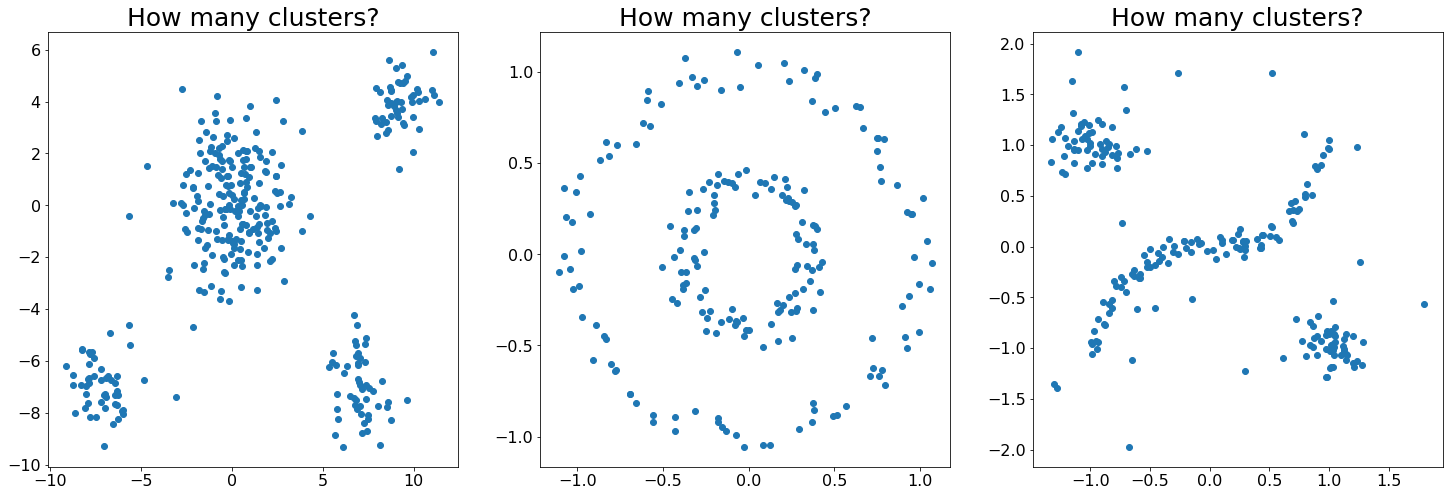

In [47]:
plot_example_density(25,8)

**Question:** How can we tell how many clusters are in the plots above?

<br><br><br><br><br><br>

One definition is that, inside the clusters we have higher density of points than outsides the clusters;

#### Let's work with the idea of density

- We will say that, to be part of a cluster, each point must have at least _some number of neighbors_ in a given _radius_. 

To work with this idea, we need three things:

   - Define how many neighbor points we require.
   - The neighborhood size parameter.
   - The neighborhood shape: this will be defined by the distance metric used.

In [48]:
# ?DBSCAN

- DBSCAN clustering works this way, and can fit shapes than $k$-means cannot.
- We will not go into the details (it classifies each point as either a "core point" or "border point").


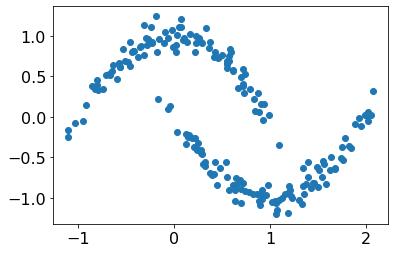

In [49]:
n1 = 100
x1 = np.linspace(-1,1,n1) + np.random.randn(n1)*.1
y1 = 1-x1**2 + np.random.randn(n1)*.1
n2 = 100
x2 = np.linspace(0,2,n2) + np.random.randn(n2)*.1
y2 = (x2-1)**2-1 + np.random.randn(n2)*.1
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
plt.scatter(x,y)
X = np.concatenate((x[:,None],y[:,None]),axis=1)

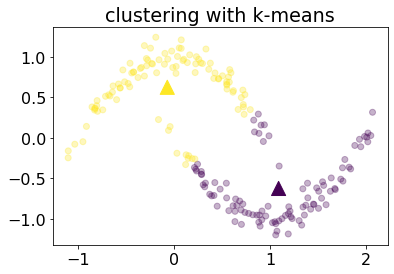

In [50]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)
plt.title("clustering with k-means");

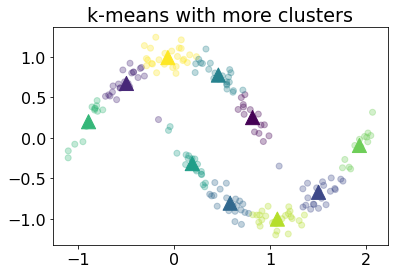

In [51]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)
plt.title("k-means with more clusters");

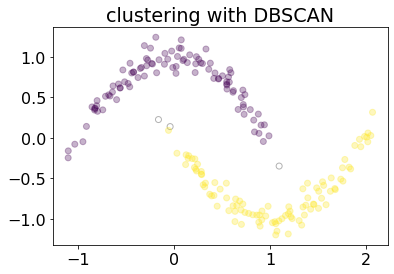

In [52]:
dbscan = DBSCAN(eps=0.3)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)
plt.title("clustering with DBSCAN");

#### Effect of the DBSCAN hyperparameters

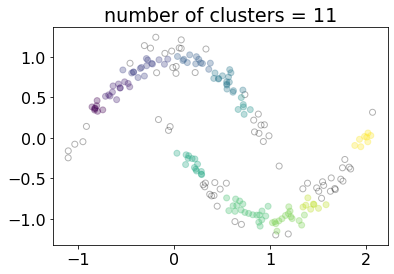

In [53]:
dbscan = DBSCAN(eps=0.1)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

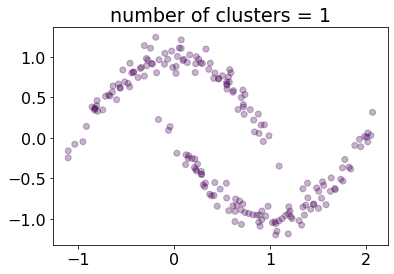

In [54]:
dbscan = DBSCAN(eps=1)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

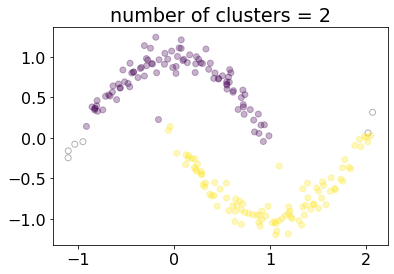

In [55]:
dbscan = DBSCAN(eps=0.5, min_samples=25)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

Note that we did not tell it the number of clusters - it reported this back to us when it finished.

#### An example where $k$-means works better

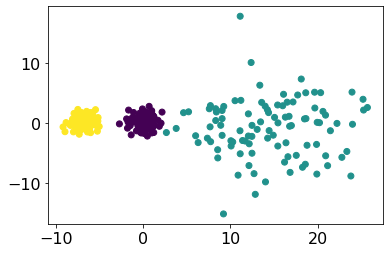

In [56]:
# collapse this cell

n1 = 100
μ1 = [0,0]
σ1 = 1
X1 = σ1*np.random.randn(n1,2) + μ1

n2 = 100
μ2 = [15,0]
σ2 = 5
X2 = σ2*np.random.randn(n2,2) + μ2

n3 = 100
μ3 = [-7,0]
σ3 = 1
X3 = σ3*np.random.randn(n3,2) + μ3


X = np.concatenate((X1,X2,X3))
z_true = np.concatenate((np.zeros(n1),np.ones(n2),np.ones(n2)+1))

plt.scatter(X[:,0],X[:,1], c=z_true);

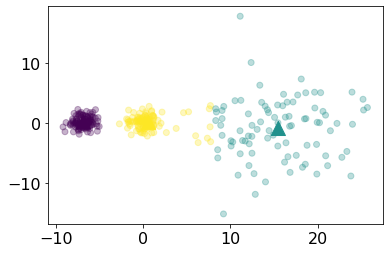

In [57]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)

$k$-means performs reasonably here, although of course it gets the benefit of me telling it the true number of clusters.

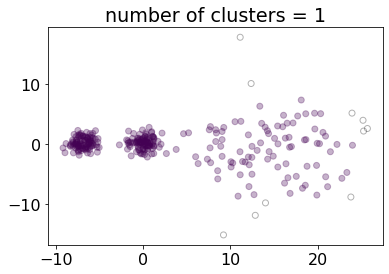

In [58]:
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

This doesn't look too great. You can try fiddling with the hyperparameters of DBSCAN here. The example is problematic because we have two different densities of clusters, and yet the `eps` parameter roughly sets a single density of cluster that we're looking for. If we make `eps` large enough to keep the non-dense (right-hand) cluster together, then it'll also end up joining the left two clusters.

Comparing $k$-means vs. DBSCAN:

For n_clusters = 2 The average silhouette_score is : 0.6739922119647256
For n_clusters = 3 The average silhouette_score is : 0.6251217732530461
For n_clusters = 4 The average silhouette_score is : 0.6058150851898764


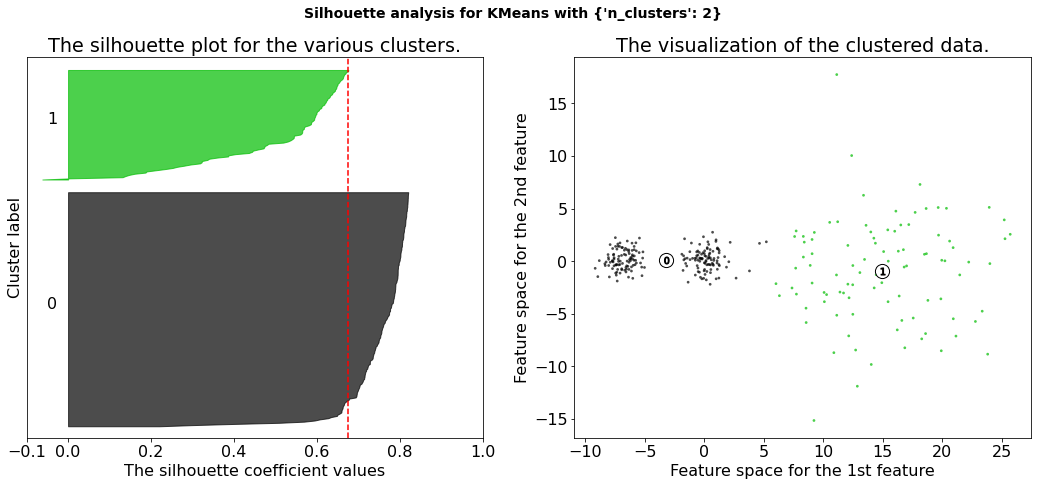

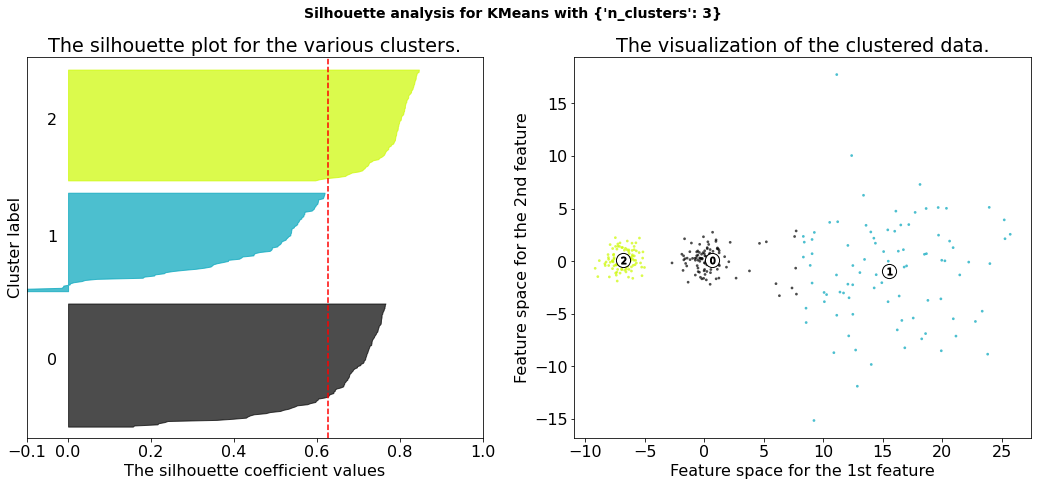

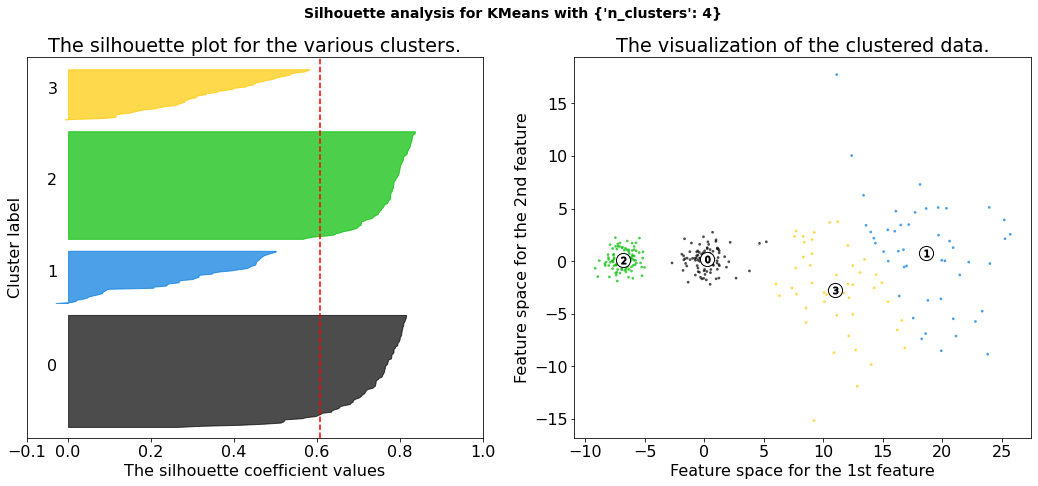

In [59]:
make_sklearn_sil_plots(X, [{"n_clusters" : n} for n in [2,3,4]])

We can make the plots for DBSCAN as well, although we have to decide how to handle un-assigned points (currently ignoring them):

For n_clusters = 3 The average silhouette_score is : 0.49952033207204644
For n_clusters = 3 The average silhouette_score is : 0.565176844697721
For n_clusters = 1 The average silhouette_score is : 0.42083321481288377


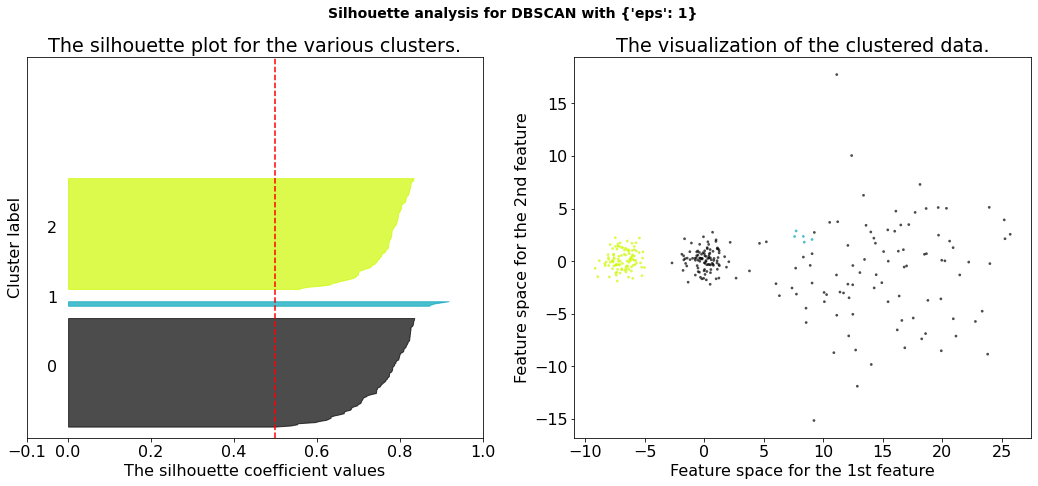

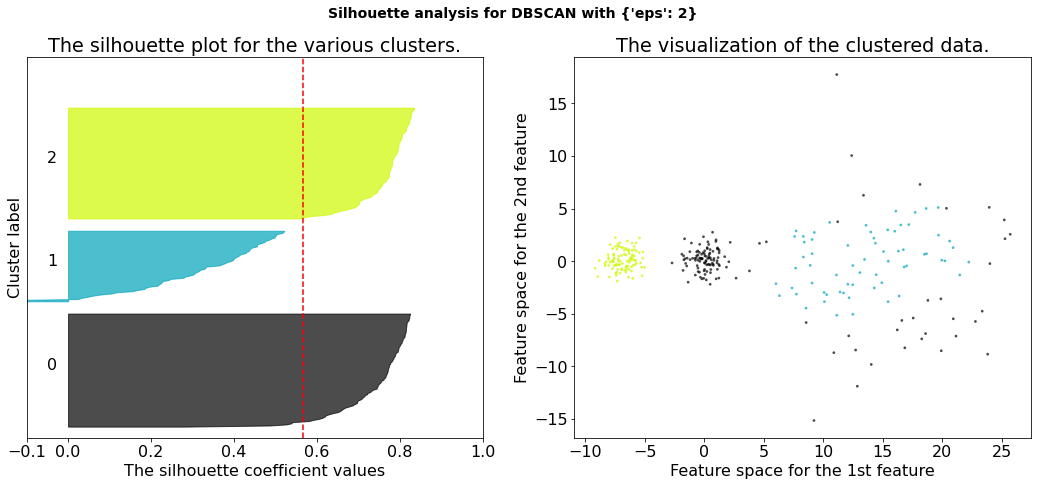

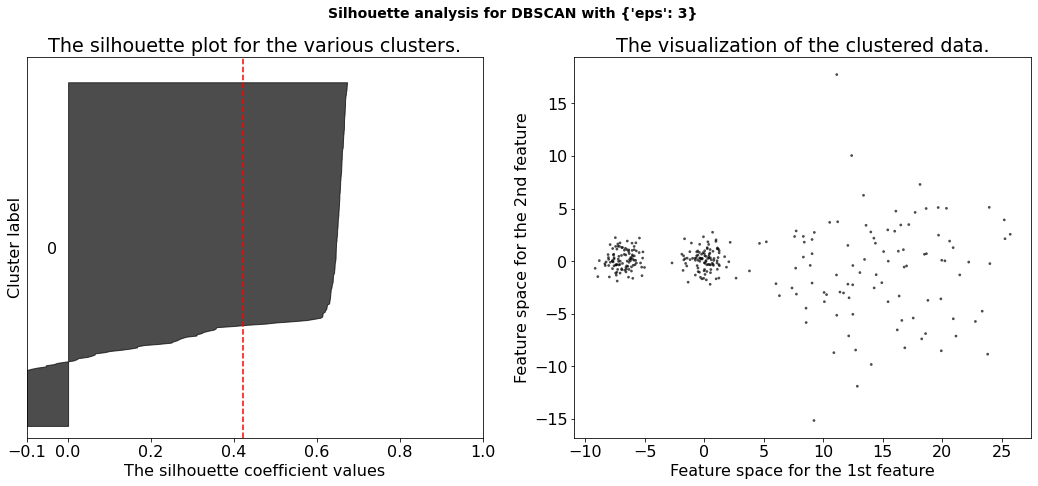

In [60]:
make_sklearn_sil_plots(X, [{"eps" : eps} for eps in [1,2,3]], DBSCAN)

In [61]:
np.max(dbscan.labels_) + 1

1

There's a nice comparison of sklearn clustering algorithms [here](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods).

## Hierarchical Clustering (10 min)

- Looking at the previous plot, maybe the two smaller clusters on the left are sub-clusters of a larger left cluster?
- Solution: in a step-by-step way, merge (or divide) the existing clusters.

#### Agglomerative Clustering

- Agglomerative clustering works by merging clusters.
- The overall idea is.
    1. Start with each point as a separate cluster.
    2. Merge the clusters that are most similar to each other.
    3. Repeat Step 2 until you obtain only one cluster ($n-1$ times).


We'll use a dataset of votes on UN resolutions:

In [62]:
votes = pd.read_csv("data/subvotes.csv")
votes.head()

,rcid,country,vote
0,2491,USA,1
1,2491,Canada,1
2,2491,Bahamas,1
3,2491,Cuba,3
4,2491,Jamaica,1


First we "pivot" the table:

In [63]:
votes = votes.pivot(index='country', columns='rcid')
votes = votes[np.sum(np.isnan(votes), axis=1)<1]
votes.head()

vote                                               ...            \
rcid      2491 2492 2497 2504 2510 2526 2563 2610 2641 2645  ... 5321 5333   
country                                                      ...             
Australia  1.0  2.0  1.0  3.0  3.0  3.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
Austria    1.0  1.0  1.0  2.0  2.0  2.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
Brazil     1.0  1.0  1.0  1.0  1.0  2.0  2.0  3.0  1.0  1.0  ...  1.0  1.0   
Colombia   1.0  1.0  1.0  1.0  1.0  2.0  1.0  2.0  1.0  1.0  ...  1.0  1.0   
Denmark    1.0  1.0  1.0  2.0  2.0  3.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   

                                                   
rcid      5337 5358 5363 5364 5365 5367 5383 5385  
country                                            
Australia  1.0  1.0  2.0  1.0  3.0  1.0  3.0  3.0  
Austria    1.0  1.0  2.0  2.0  2.0  1.0  3.0  3.0  
Brazil     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Colombia   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Denmark    1.0  1.0  2.0  2.0  2.0  1.0  3.0  3.0  

[5 rows x 368 columns]

In [64]:
votes.shape

(17, 368)

- We have 17 countries, 368 votes. 
- Let's try to cluster the countries based on how they votes.

First, we take the distances between countries:

In [65]:
dist = pd.DataFrame(distance.cdist(votes,votes, metric="hamming"))
dist.index = votes.index
dist.columns = votes.index
dist.head()

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA
country,,,,,,,,,,,,,,,,,
Australia,0.000000,0.239130,0.456522,0.483696,0.198370,0.263587,0.233696,0.274457,0.597826,0.228261,0.206522,0.377717,0.239130,0.255435,0.603261,0.258152,0.347826
Austria,0.239130,0.000000,0.364130,0.331522,0.086957,0.086957,0.116848,0.146739,0.524457,0.125000,0.092391,0.206522,0.111413,0.059783,0.521739,0.195652,0.489130
Brazil,0.456522,0.364130,0.000000,0.255435,0.399457,0.415761,0.415761,0.434783,0.293478,0.429348,0.396739,0.220109,0.421196,0.385870,0.290761,0.475543,0.657609
Colombia,0.483696,0.331522,0.255435,0.000000,0.385870,0.399457,0.407609,0.423913,0.312500,0.410326,0.383152,0.187500,0.407609,0.364130,0.312500,0.470109,0.679348
Denmark,0.198370,0.086957,0.399457,0.385870,0.000000,0.081522,0.062500,0.138587,0.562500,0.054348,0.035326,0.250000,0.065217,0.076087,0.554348,0.135870,0.453804


- Next, we set the diagonal elements to a large number, so that the closest country to Australia isn't Australia.
- (We had a similar issue with nearest neighbours a few classes ago)

In [66]:
dist.values[tuple([np.arange(votes.shape[0])]*2)] = np.inf
dist.head()

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA
country,,,,,,,,,,,,,,,,,
Australia,inf,0.239130,0.456522,0.483696,0.198370,0.263587,0.233696,0.274457,0.597826,0.228261,0.206522,0.377717,0.239130,0.255435,0.603261,0.258152,0.347826
Austria,0.239130,inf,0.364130,0.331522,0.086957,0.086957,0.116848,0.146739,0.524457,0.125000,0.092391,0.206522,0.111413,0.059783,0.521739,0.195652,0.489130
Brazil,0.456522,0.364130,inf,0.255435,0.399457,0.415761,0.415761,0.434783,0.293478,0.429348,0.396739,0.220109,0.421196,0.385870,0.290761,0.475543,0.657609
Colombia,0.483696,0.331522,0.255435,inf,0.385870,0.399457,0.407609,0.423913,0.312500,0.410326,0.383152,0.187500,0.407609,0.364130,0.312500,0.470109,0.679348
Denmark,0.198370,0.086957,0.399457,0.385870,inf,0.081522,0.062500,0.138587,0.562500,0.054348,0.035326,0.250000,0.065217,0.076087,0.554348,0.135870,0.453804


- We need the pairwise dissimilarities of the clusters.
- We start with each country as a separate cluster.

In [67]:
dist

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA
country,,,,,,,,,,,,,,,,,
Australia,inf,0.239130,0.456522,0.483696,0.198370,0.263587,0.233696,0.274457,0.597826,0.228261,0.206522,0.377717,0.239130,0.255435,0.603261,0.258152,0.347826
Austria,0.239130,inf,0.364130,0.331522,0.086957,0.086957,0.116848,0.146739,0.524457,0.125000,0.092391,0.206522,0.111413,0.059783,0.521739,0.195652,0.489130
Brazil,0.456522,0.364130,inf,0.255435,0.399457,0.415761,0.415761,0.434783,0.293478,0.429348,0.396739,0.220109,0.421196,0.385870,0.290761,0.475543,0.657609
Colombia,0.483696,0.331522,0.255435,inf,0.385870,0.399457,0.407609,0.423913,0.312500,0.410326,0.383152,0.187500,0.407609,0.364130,0.312500,0.470109,0.679348
Denmark,0.198370,0.086957,0.399457,0.385870,inf,0.081522,0.062500,0.138587,0.562500,0.054348,0.035326,0.250000,0.065217,0.076087,0.554348,0.135870,0.453804
Finland,0.263587,0.086957,0.415761,0.399457,0.081522,inf,0.127717,0.157609,0.586957,0.127717,0.097826,0.274457,0.116848,0.097826,0.557065,0.201087,0.519022
Italy,0.233696,0.116848,0.415761,0.407609,0.062500,0.127717,inf,0.111413,0.562500,0.029891,0.084239,0.271739,0.019022,0.081522,0.543478,0.108696,0.440217
Japan,0.274457,0.146739,0.434783,0.423913,0.138587,0.157609,0.111413,inf,0.570652,0.105978,0.146739,0.296196,0.103261,0.127717,0.576087,0.165761,0.472826
Malaysia,0.597826,0.524457,0.293478,0.312500,0.562500,0.586957,0.562500,0.570652,inf,0.581522,0.562500,0.380435,0.567935,0.559783,0.119565,0.625000,0.758152


In [68]:
dist.min(axis=0).sort_values()

country
Italy          0.019022
Portugal       0.019022
Netherlands    0.029891
Denmark        0.035326
Norway         0.035326
Austria        0.059783
Spain          0.059783
Finland        0.081522
UK             0.092391
Japan          0.103261
Malaysia       0.119565
Sri Lanka      0.119565
Colombia       0.187500
Peru           0.187500
Australia      0.198370
Brazil         0.220109
USA            0.347826
dtype: float64

- The minimum distance is between Italy and Portugal.
- Step 2: merge the clusters that are most similar to each other:
  - We put Italy and Portugal into the same cluster.
- Next, we recalculate the distances between the clusters.

#### How to measure clusters' dissimilarity?

- But what is the distance between the cluster (Italy, Portugal) and the other countries?
- Some strategies:
    - Minimum distance (Single Linkage)
    - Maximum distance (Complete Linkage)
    - Average distance (Average Linkage)

We'll use single linkage in the example here:

In [69]:
dist2 = dist.copy()
new_cluster = dist2.loc[('Italy','Portugal'),:].min(axis=0).drop(index=['Italy', 'Portugal'])
new_cluster = new_cluster.rename('(Italy, Portugal)')

dist2['(Italy, Portugal)'] = new_cluster
dist2 = dist2.append(new_cluster, ignore_index=False)
dist2.iloc[-1,-1]=600
# dist2.loc[('Italy','Portugal', '(Italy, Portugal)'),:]

# Now we remove Italy and Portugal, since we don't have these two clusters anymore
# But only the (Italy, Portugal) cluster;

dist2 = dist2.drop(index=['Italy', 'Portugal'])
dist2 = dist2.drop('Italy', axis=1)
dist2 = dist2.drop('Portugal', axis=1)
dist2

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Japan,Malaysia,Netherlands,Norway,Peru,Spain,Sri Lanka,UK,USA,"(Italy, Portugal)"
country,,,,,,,,,,,,,,,,
Australia,inf,0.239130,0.456522,0.483696,0.198370,0.263587,0.274457,0.597826,0.228261,0.206522,0.377717,0.255435,0.603261,0.258152,0.347826,0.233696
Austria,0.239130,inf,0.364130,0.331522,0.086957,0.086957,0.146739,0.524457,0.125000,0.092391,0.206522,0.059783,0.521739,0.195652,0.489130,0.111413
Brazil,0.456522,0.364130,inf,0.255435,0.399457,0.415761,0.434783,0.293478,0.429348,0.396739,0.220109,0.385870,0.290761,0.475543,0.657609,0.415761
Colombia,0.483696,0.331522,0.255435,inf,0.385870,0.399457,0.423913,0.312500,0.410326,0.383152,0.187500,0.364130,0.312500,0.470109,0.679348,0.407609
Denmark,0.198370,0.086957,0.399457,0.385870,inf,0.081522,0.138587,0.562500,0.054348,0.035326,0.250000,0.076087,0.554348,0.135870,0.453804,0.062500
Finland,0.263587,0.086957,0.415761,0.399457,0.081522,inf,0.157609,0.586957,0.127717,0.097826,0.274457,0.097826,0.557065,0.201087,0.519022,0.116848
Japan,0.274457,0.146739,0.434783,0.423913,0.138587,0.157609,inf,0.570652,0.105978,0.146739,0.296196,0.127717,0.576087,0.165761,0.472826,0.103261
Malaysia,0.597826,0.524457,0.293478,0.312500,0.562500,0.586957,0.570652,inf,0.581522,0.562500,0.380435,0.559783,0.119565,0.625000,0.758152,0.562500
Netherlands,0.228261,0.125000,0.429348,0.410326,0.054348,0.127717,0.105978,0.581522,inf,0.078804,0.279891,0.092391,0.562500,0.092391,0.429348,0.029891


And now we repeat:

In [70]:
dist2.min(axis=0).sort_values()

country
Netherlands          0.029891
(Italy, Portugal)    0.029891
Denmark              0.035326
Norway               0.035326
Austria              0.059783
Spain                0.059783
Finland              0.081522
UK                   0.092391
Japan                0.103261
Malaysia             0.119565
Sri Lanka            0.119565
Colombia             0.187500
Peru                 0.187500
Australia            0.198370
Brazil               0.220109
USA                  0.347826
dtype: float64

- By doing this iteratively, we will end up with only one cluster.
- We are interested in the results in the middle, with a reasonable number of clusters.
- We can use any distance metric.
- Different distances that provide the same orderings will not affect single linkages.

In [71]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [72]:
# ?linkage

In [73]:
def plot_dendrogram(w,h, method, metric):

    Z = linkage(votes, method=method, metric=metric)
    w = 22
    h = 10
    fig, ax = plt.subplots(figsize=(w,h))
    dendrogram(Z, labels = votes.index, ax=ax);
    ax = plt.gca()
    ax.set_ylabel("Distance", fontsize=w)
    #ax.set_yticklabels(ax.get_yticklabels(), fontsize=w);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, fontsize=w)


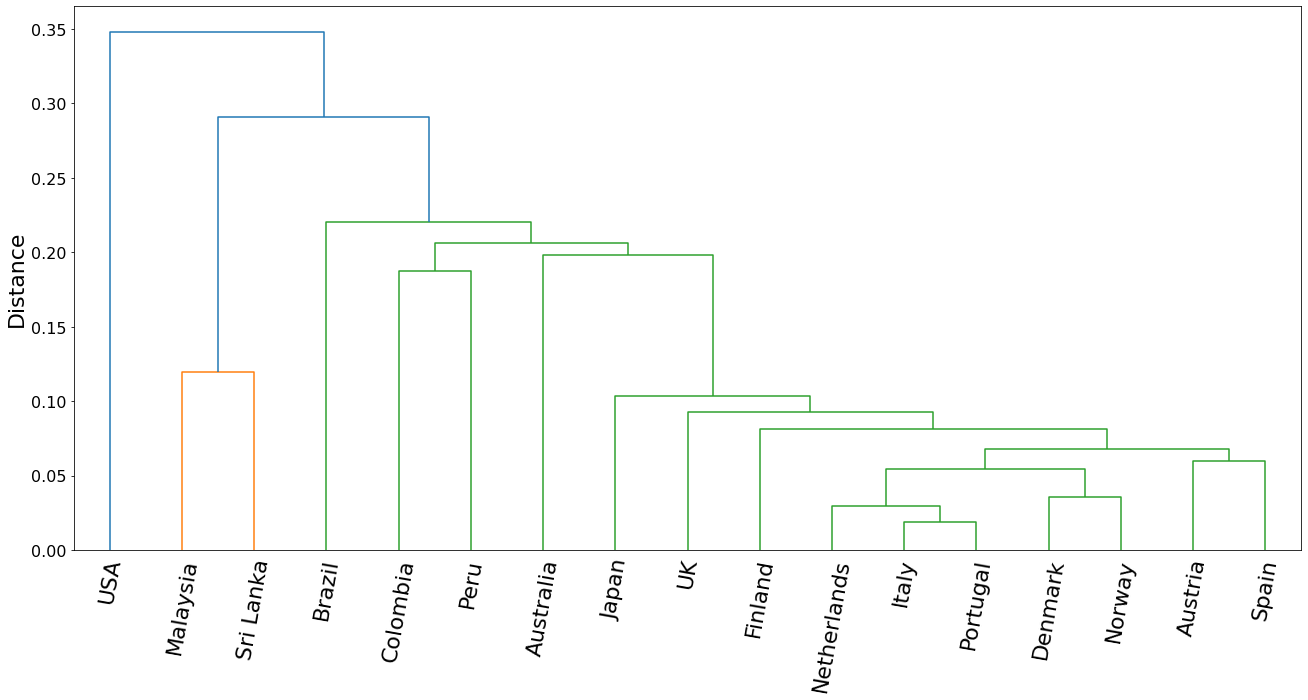

In [74]:
plot_dendrogram(22, 10, 'single', 'hamming')

#### Hierarchical Clustering in Python

- Unfortunately, `sklearn` does not support this.
- For hierarchical clustering, the package [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) is helpful.
- You might need these three functions from `scipy.cluster.hierarchy`: 
    - [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
    - [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram)
    - [fcluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster)

#### Understanding the output of `linkage`

- The function `linkage` will return a matrix (n-1)x4:
    - First and second columns: indexes of the clusters being merged.
    - Third column: the distance between the clusters being merged.
    - Fourth column: the number of elements in the newly formed cluster.
    
- The rows represent the iterations.

In [75]:
linkage(votes, metric='cityblock')

array([[  6.,  12.,   7.,   2.],
       [  9.,  17.,  13.,   3.],
       [  4.,  10.,  15.,   2.],
       [ 18.,  19.,  22.,   5.],
       [  1.,  13.,  22.,   2.],
       [ 20.,  21.,  26.,   7.],
       [  5.,  22.,  32.,   8.],
       [  7.,  23.,  41.,   9.],
       [ 15.,  24.,  47.,  10.],
       [  8.,  14.,  48.,   2.],
       [  3.,  11.,  70.,   2.],
       [  0.,  25.,  77.,  11.],
       [  2.,  27.,  81.,   3.],
       [ 28.,  29.,  87.,  14.],
       [ 26.,  30., 119.,  16.],
       [ 16.,  31., 189.,  17.]])

- If you want to truncate the tree in the dendrogram (specially when you have a big $n$) you can use
    - `dendrogram(output_linkage, desired_n_cluster, truncate_mode='lastp')` 
    

- Alternatively, you can truncate the tree down to $x$ levels from the single cluster:
    - `dendrogram(output_linkage, x, truncate_mode='level')` 

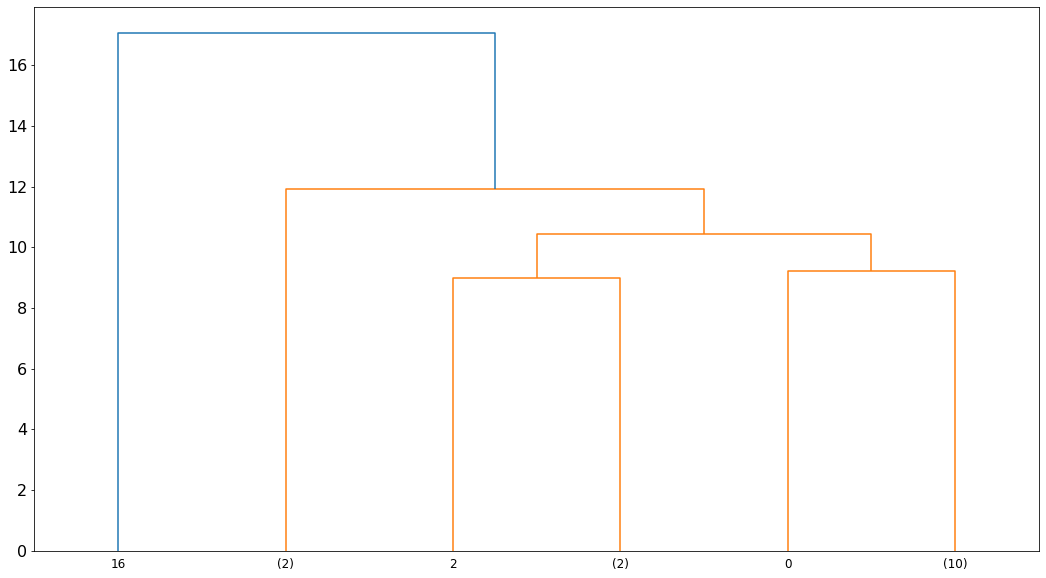

In [76]:
Z = linkage(votes)
fig, ax = plt.subplots(figsize=(18,10))
dendrogram(Z, 6, truncate_mode='lastp', ax=ax);

- The output matrix from the `linkage` function might be of little use other than for the dendrogram;
- To bring the clustering to a "flat" format, we can use
    - `fcluster(output_linkage, n_cluster, criterion='maxclust')`
<br>
<br>

In [77]:
fcluster(Z, 6, criterion='maxclust')

array([5, 4, 3, 2, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4, 1, 4, 6], dtype=int32)

All this is fairly similar to the nearest neighbours we talked about earlier, except we are extending it to clusters instead of just examples.

## True/False questions

1. A clustering of $n$ points with 10 clusters will always have a smaller total intra-cluster distance than a clustering with 5 clusters. 
2. With $k$-means clustering, we are sometimes interested in the cluster assignments of training points and sometimes in the cluster means. 
3. With DBSCAN, we are sometimes interested in the cluster assignments and sometimes in the cluster means. 
4. With agglomerative hierarchical clustering, we need a way to compute the distance between two clusters.
